## BaseLine Heuristic Model

### By:
[Jose R. Zapata](https://joserzapata.github.io/)

### Date:
2024-10-29

### Description:

Create a baseline model using a heuristic approach. The model will be based on the data analysis in this notebook <https://github.com/JoseRZapata/demo-data-science-template/blob/main/notebooks/3-analysis/02-jrz-data_description_Manual-pandas-2024_10_24.ipynb>

The model will be based on the following rules base on the data analysis:

1. If `sex` = `female` and `pclass` < 3  , then survived
2. If `age` <=5 or  `age` is between 10 and 15  , then survived
3. else, not survived

## 📚 Import  libraries

In [1]:
# base libraries for data science
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import (
    KFold,
    ShuffleSplit,
    cross_val_score,
    learning_curve,
    train_test_split,
)
from sklearn.pipeline import Pipeline

## 💾 Load data

In [2]:
DATA_DIR = Path.cwd().resolve().parents[1] / "data"

titanic_df = pd.read_parquet(
    DATA_DIR / "02_intermediate/titanic_type_fixed.parquet", engine="pyarrow"
)

In [3]:
# print library version for reproducibility

print("Pandas version: ", pd.__version__)

Pandas version:  2.1.4


## 👷 Data preparation

base on the rules above, for the heuristic model only 3 columns are needed: `sex`, `pclass`, and `age`.

In [4]:
selected_features = ["sex", "pclass", "age", "survived"]

titanic_features = titanic_df[selected_features]

titanic_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   sex       1309 non-null   category
 1   pclass    1309 non-null   int64   
 2   age       1046 non-null   float64 
 3   survived  1309 non-null   bool    
dtypes: bool(1), category(1), float64(1), int64(1)
memory usage: 23.3 KB


In [5]:
titanic_features.isna().sum()

sex           0
pclass        0
age         263
survived      0
dtype: int64

The target variable is `survived` and the values are True or False.
I'm going to transform the target variable to 1 or 0.

In [6]:
titanic_features.loc[:, "survived"] = titanic_features["survived"].astype(int)

drop duplicates if any exist in the dataset, is important to avoid any bias in the dataset or data leakage when a machine learning model is trained on the data.

But for a heuristic model, the duplicates don't affect the model.

In [7]:
len(titanic_features.drop_duplicates())

434

After select only 3 columns theres a lot of duplicates, then more columns are selected the probability of duplicates is lower.

I'm Not going to drop duplicates in this case. to keep the 1309 rows to compare with the machine learning models that uses more columns.

In [8]:
titanic_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   sex       1309 non-null   category
 1   pclass    1309 non-null   int64   
 2   age       1046 non-null   float64 
 3   survived  1309 non-null   int64   
dtypes: category(1), float64(1), int64(2)
memory usage: 32.2 KB


In [9]:
titanic_features.sample(10, random_state=42)

,sex,pclass,age,survived
1148,male,3,35.0,0
1049,male,3,20.0,1
982,male,3,NaN,0
808,male,3,NaN,0
1195,male,3,NaN,0
240,male,1,45.0,1
1118,male,3,25.0,0
596,male,2,31.0,1
924,male,3,34.5,0
65,female,1,33.0,1


## 👨‍🏭 Feature Engineering

In [10]:
cols_numeric = ["age"]
cols_categoric = ["sex"]
cols_categoric_ord = ["pclass"]

`age` column needs imputation, for this model, we will use the median value. but categorical columns don't need nothing for this heuristic model.

In [11]:
numeric_pipe = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
    ]
)
# the order of the columns and the pipelines matters
preprocessor = ColumnTransformer(
    transformers=[
        # passthrough output is equal to input
        ("categoric", "passthrough", cols_categoric),
        # passthrough output is equal to input
        ("categoric ordinal", "passthrough", cols_categoric_ord),
        ("numeric", numeric_pipe, cols_numeric),
    ]
)

In [12]:
preprocessor

ColumnTransformer(transformers=[('categoric', 'passthrough', ['sex']),
                                ('categoric ordinal', 'passthrough',
                                 ['pclass']),
                                ('numeric',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median'))]),
                                 ['age'])])

Example of the data preprocessing

In [13]:
data_example = titanic_features.drop(columns="survived").sample(10, random_state=42)
data_example

,sex,pclass,age
1148,male,3,35.0
1049,male,3,20.0
982,male,3,NaN
808,male,3,NaN
1195,male,3,NaN
240,male,1,45.0
1118,male,3,25.0
596,male,2,31.0
924,male,3,34.5
65,female,1,33.0


In [14]:
preprocessor.fit_transform(data_example)

array([['male', 3, 35.0],
       ['male', 3, 20.0],
       ['male', 3, 33.0],
       ['male', 3, 33.0],
       ['male', 3, 33.0],
       ['male', 1, 45.0],
       ['male', 3, 25.0],
       ['male', 2, 31.0],
       ['male', 3, 34.5],
       ['female', 1, 33.0]], dtype=object)

The data input for the heuristic model is like the above example

## Train / Test split

In [15]:
X_features = titanic_features.drop("survived", axis="columns")
Y_target = titanic_features["survived"]

# 80% train, 20% test
x_train, x_test, y_train, y_test = train_test_split(
    X_features, Y_target, test_size=0.2, stratify=Y_target
)

In [16]:
x_train.shape, y_train.shape

((1047, 3), (1047,))

In [17]:
x_test.shape, y_test.shape

((262, 3), (262,))

## Model

In [18]:
class HeuristicModel(BaseEstimator, ClassifierMixin):
    """Heuristic model for Titanic dataset compatible with scikit-learn"""

    def fit(self, X, y=None):
        # Don't do anything
        if y is not None:
            self.classes_ = np.unique(y)
        return self

    def predict(self, X):
        SEX = "female"
        PCLASS_THRESHOLD = 3
        AGE_THRESHOLD_1 = 5
        AGE_THRESHOLD_2_LOW = 10
        AGE_THRESHOLD_2_HIGH = 15
        predictions = []
        for input in X:
            if (
                (input[0] == SEX) & (input[1] < PCLASS_THRESHOLD)
                or (input[2] <= AGE_THRESHOLD_1)
                or (
                    (input[2] >= AGE_THRESHOLD_2_LOW)
                    & (input[2] <= AGE_THRESHOLD_2_HIGH)
                )
            ):
                predictions.append(1)
            else:
                predictions.append(0)
        return np.array(predictions)

## Predict and Evaluation

accuracy - CV mean: 0.7965109890109889, CV std: 0.04109125938205496
accuracy - Train score: 0.7965616045845272
f1 - CV mean: 0.669680265704232, CV std: 0.06457666510160656
f1 - Train score: 0.7965616045845272
precision - CV mean: 0.8729100384317775, CV std: 0.062192465962973634
precision - Train score: 0.7965616045845272
recall - CV mean: 0.5455741214409946, CV std: 0.0714390800017646
recall - Train score: 0.7965616045845272


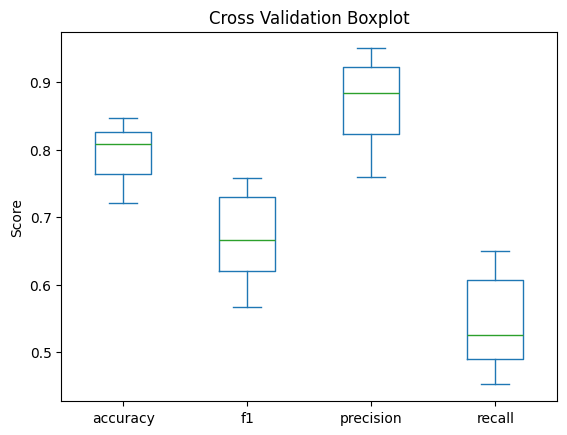

In [19]:
# Model
model = HeuristicModel()

# Evaluation metrics
scoring_metrics = ["accuracy", "f1", "precision", "recall"]

# KFold for the cross-validation
kfold = KFold(n_splits=10)

# Model pipeline = preprocessor + model
model_pipe = Pipeline(steps=[("preprocessor", preprocessor), ("model", model)])

# Variable to store the results of the cross-validation
cv_results = {}
train_results = {}

# Cross-validation evaluation for each metric
for metric in scoring_metrics:
    cv_results[metric] = cross_val_score(
        model_pipe, x_train, y_train, cv=kfold, scoring=metric
    )
    # Evaluate on the training set
    model_pipe.fit(x_train, y_train)
    train_results[metric] = model_pipe.score(x_train, y_train)

# Convert results into a pandas DataFrame
cv_results_df = pd.DataFrame(cv_results)

# Print the mean and standard deviation for each metric
for metric_name in scoring_metrics:
    print(
        f"{metric_name} - CV mean: {cv_results_df[metric_name].mean()}, "
        f"CV std: {cv_results_df[metric_name].std()}"
    )
    print(f"{metric_name} - Train score: {train_results[metric_name]}")

# Create a boxplot for the cross-validation results of each metric
cv_results_df.plot.box(title="Cross Validation Boxplot", ylabel="Score");

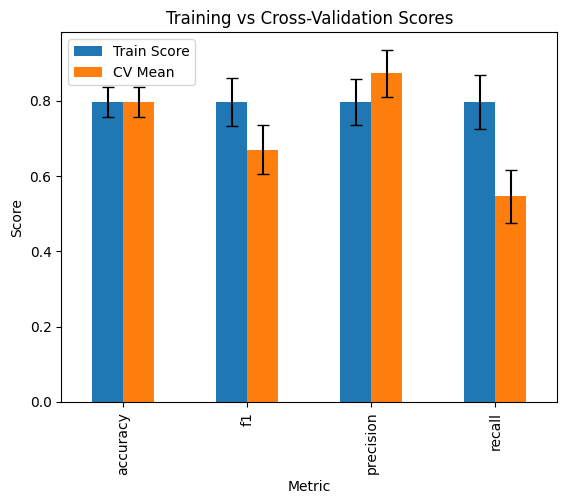

In [20]:
# Create a DataFrame for the training and cross-validation metrics
metrics_df = pd.DataFrame(
    {
        "Metric": scoring_metrics,
        "Train Score": [train_results[metric] for metric in scoring_metrics],
        "CV Mean": [cv_results_df[metric].mean() for metric in scoring_metrics],
        "CV Std": [cv_results_df[metric].std() for metric in scoring_metrics],
    }
)

# Create a bar plot for the training and cross-validation metrics
metrics_df.plot(
    kind="bar",
    x="Metric",
    y=["Train Score", "CV Mean"],
    yerr="CV Std",
    title="Training vs Cross-Validation Scores",
    ylabel="Score",
    capsize=4,
);

 ### Analysis of the results of all metrics
 
1. **Accuracy**:

    - CV Mean: 0.7928571428571428
    - CV Std: 0.05642933132927799
    - Train Score: 0.792741165234002
    - Interpretation: The accuracy on the training set is very close to the cross-validation mean accuracy, with a slight difference. The standard deviation indicates moderate variability in accuracy across different folds.

2. **F1 Score:**

    - CV Mean: 0.672259965602412
    - CV Std: 0.08472310093970331
    - Train Score: 0.792741165234002
    - Interpretation: The F1 score on the training set is significantly higher than the cross-validation mean F1 score. The high standard deviation suggests considerable variability in the F1 score across different folds.

3. **Precision**:

    - CV Mean: 0.8483034947457538
    - CV Std: 0.07901968288730099
    - Train Score: 0.792741165234002
    - Interpretation: The precision on the training set is lower than the cross-validation mean precision. The standard deviation indicates moderate variability in precision across different folds.

4. **Recall**:

    - CV Mean: 0.5601543135490643
    - CV Std: 0.0887461096456135
    - Train Score: 0.792741165234002
    - Interpretation: The recall on the training set is significantly higher than the cross-validation mean recall. The high standard deviation suggests considerable variability in recall across different folds.


## Final Evaluation

In [21]:
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    PrecisionRecallDisplay,
    classification_report,
)

In [22]:
y_pred = model_pipe.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.88      0.81       162
           1       0.73      0.53      0.61       100

    accuracy                           0.74       262
   macro avg       0.74      0.70      0.71       262
weighted avg       0.74      0.74      0.73       262



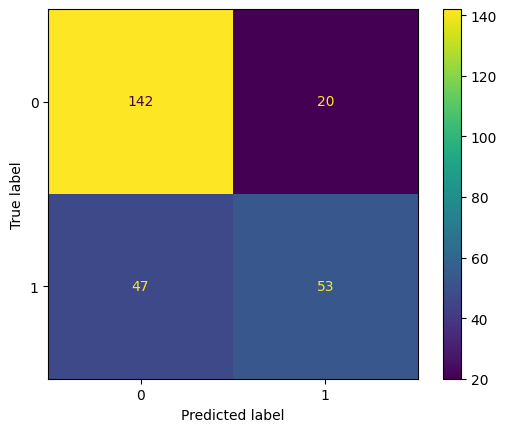

In [23]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred);

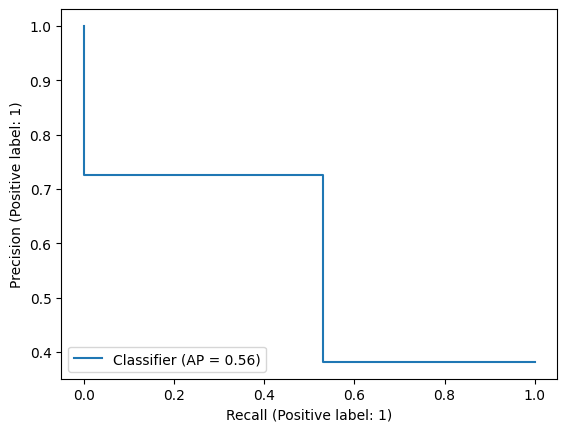

In [24]:
PrecisionRecallDisplay.from_predictions(y_test, y_pred);

### Only one Metric (Recall)

The  Recall (Sensitivity or True Positive Rate) metric is chosen for this model because it is more important to identify all positive cases (survivors) in order to take appropriate actions.

The objetive of this model is to identify all the survivors with out missing any of them, hypothetically the model is going to be used to take actions to save the passengers, so the recall metric is the most important metric for this model.

Recall is important because it Measures the model's ability to correctly identify passengers who survived. It is crucial in situations where it is more important to identify all positive cases (survivors) in order to take appropriate actions, and it is not as important to identify negative cases (non-survivors). The False Negative (FN) is the most important error in this case.




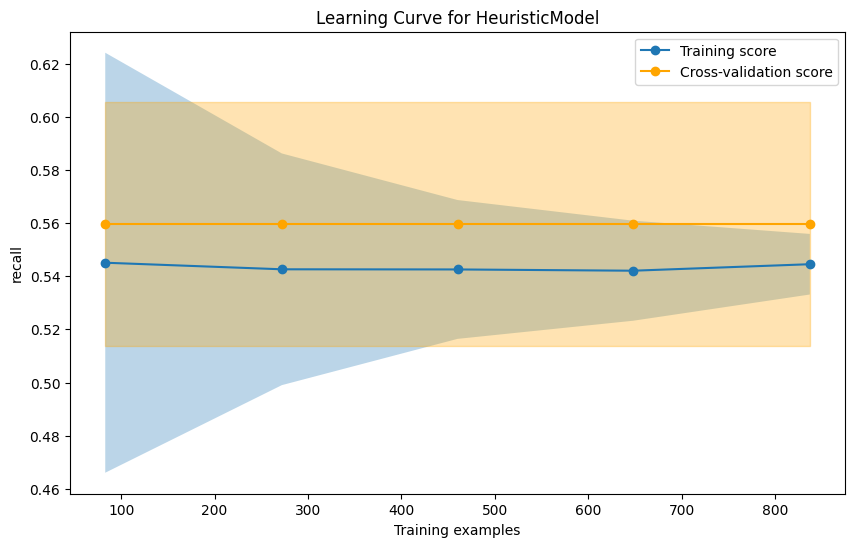

Training Sizes: [ 83 272 460 648 837]
Training Scores Mean: [0.54509278 0.54261765 0.54256109 0.54208533 0.54453002]
Training Scores Std: [0.07905815 0.04360966 0.02613436 0.01882922 0.01140582]
Test Scores Mean: [0.55962829 0.55962829 0.55962829 0.55962829 0.55962829]
Test Scores Std: [0.04589904 0.04589904 0.04589904 0.04589904 0.04589904]


In [25]:
# Define pipeline = preprocessor + model
model = HeuristicModel()
model_pipe = Pipeline(steps=[("preprocessor", preprocessor), ("model", model)])

# Parameters for the learning curve
common_params = {
    "X": x_train,
    "y": y_train,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": ShuffleSplit(n_splits=50, test_size=0.2, random_state=123),
    "n_jobs": -1,
    "return_times": True,
}

scoring_metric = "recall"

# Obtain the learning curve values including fit and score times
train_sizes, train_scores, test_scores, fit_times, score_times = learning_curve(
    model_pipe, **common_params, scoring=scoring_metric
)

# Calculate the mean and standard deviation of the scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Calculate the mean and standard deviation of the fit and score times
fit_times_mean = np.mean(fit_times, axis=1)
fit_times_std = np.std(fit_times, axis=1)
score_times_mean = np.mean(score_times, axis=1)
score_times_std = np.std(score_times, axis=1)

# Plot the learning curve
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6), sharey=True)
ax.plot(train_sizes, train_mean, "o-", label="Training score")
ax.plot(train_sizes, test_mean, "o-", color="orange", label="Cross-validation score")
ax.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.3)
ax.fill_between(
    train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.3, color="orange"
)

# Configure the title and labels
ax.set_title(f"Learning Curve for {model.__class__.__name__}")
ax.set_xlabel("Training examples")
ax.set_ylabel(scoring_metric)
ax.legend(loc="best")

# Show the plot
plt.show()

# Print the values for analysis
print("Training Sizes:", train_sizes)
print("Training Scores Mean:", train_mean)
print("Training Scores Std:", train_std)
print("Test Scores Mean:", test_mean)
print("Test Scores Std:", test_std)

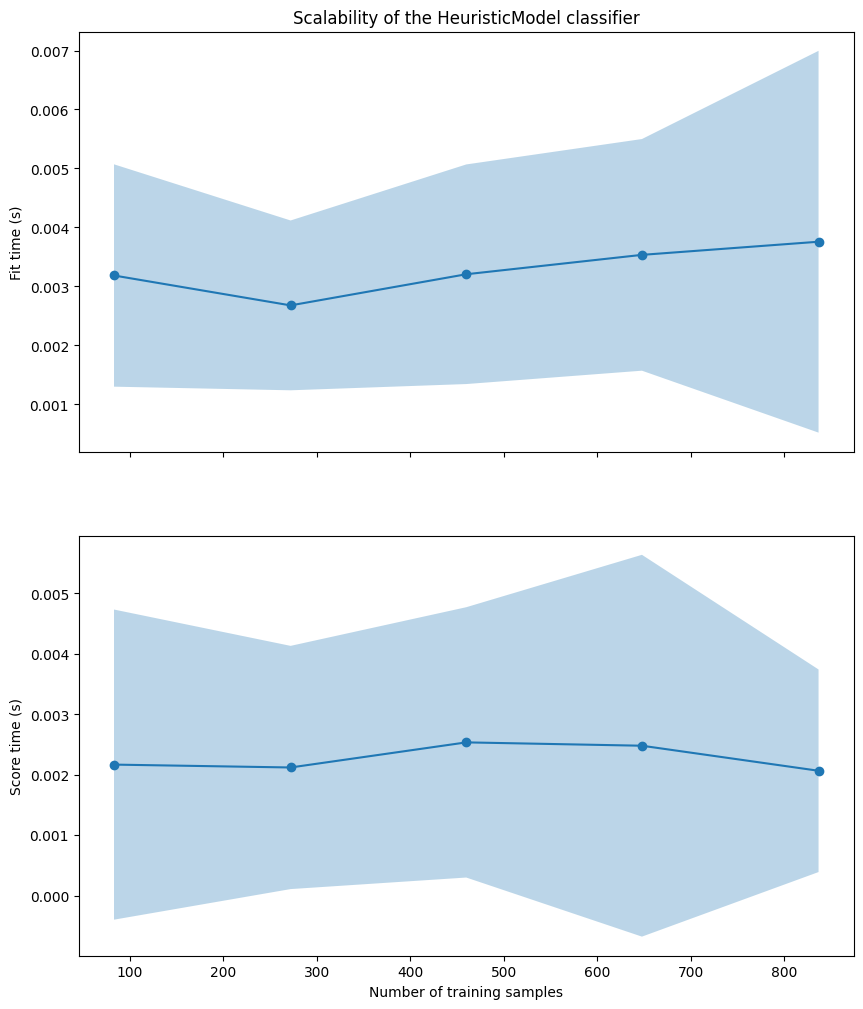

Fit Times Mean: [0.00318594 0.00267915 0.00320716 0.00353565 0.00375845]
Fit Times Std: [0.00188469 0.0014394  0.00186148 0.00196348 0.00323633]
Score Times Mean: [0.0021701  0.00212258 0.00253751 0.0024822  0.00206826]
Score Times Std: [0.0025634  0.00201031 0.00223424 0.00315579 0.00167434]


In [26]:
# Plot the scalability regarding fit time and score time
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 12), sharex=True)

# Scalability regarding the fit time
ax[0].plot(train_sizes, fit_times_mean, "o-")
ax[0].fill_between(
    train_sizes,
    fit_times_mean - fit_times_std,
    fit_times_mean + fit_times_std,
    alpha=0.3,
)
ax[0].set_ylabel("Fit time (s)")
ax[0].set_title(f"Scalability of the {model.__class__.__name__} classifier")

# Scalability regarding the score time
ax[1].plot(train_sizes, score_times_mean, "o-")
ax[1].fill_between(
    train_sizes,
    score_times_mean - score_times_std,
    score_times_mean + score_times_std,
    alpha=0.3,
)
ax[1].set_ylabel("Score time (s)")
ax[1].set_xlabel("Number of training samples")

# Show the plot
plt.show()

# Print the fit and score times for analysis
print("Fit Times Mean:", fit_times_mean)
print("Fit Times Std:", fit_times_std)
print("Score Times Mean:", score_times_mean)
print("Score Times Std:", score_times_std)

### Interpretation of the Learning Curve based on **Recall** only:




## 📊 Analysis of Results based on Recall only

### Training Scores:
- **Mean**: [0.5512, 0.5316, 0.5346, 0.5309, 0.5300]
- **Standard Deviation**: [0.0985, 0.0403, 0.0274, 0.0218, 0.0132]
- **Interpretation**: 
  - The training recall score starts at 0.5512 and slightly decreases to 0.5300 as more data is added.
  - The standard deviation decreases as the training size increases, indicating that the model's performance on the training set becomes more consistent with more data.

### Test Scores:
- **Mean**: [0.5316, 0.5316, 0.5316, 0.5316, 0.5316]
- **Standard Deviation**: [0.0544, 0.0544, 0.0544, 0.0544, 0.0544]
- **Interpretation**: 
  - The test recall score is stable at 0.5316 across all training sizes.
  - The constant standard deviation suggests that the model's performance on the test set is consistently stable across different folds of the cross-validation.

### Fit Times:
- **Mean**: [0.0112, 0.0111, 0.0110, 0.0114, 0.0116]
- **Standard Deviation**: [0.0020, 0.0030, 0.0020, 0.0024, 0.0025]
- **Interpretation**: 
  - The fit times are relatively low and stable, with a slight increase as the training size increases.
  - The standard deviation is also low, indicating consistent fit times across different folds.

### Score Times:
- **Mean**: [0.0087, 0.0091, 0.0088, 0.0090, 0.0087]
- **Standard Deviation**: [0.0025, 0.0015, 0.0014, 0.0016, 0.0015]
- **Interpretation**: 
  - The score times are low and stable, with minimal variation as the training size increases.
  - The low standard deviation indicates consistent score times across different folds.

## 📈 Conclusions

### General results:

- **Model Performance**:
  - The training and test recall scores are stable, indicating that the model performs consistently well on both the training and test sets.
  - The minimal difference between the training and test scores suggests that the model generalizes well to unseen data and is not overfitting.
- **Consistency**:
  - The decreasing standard deviation of the training scores with more data suggests that the model's performance on the training set becomes more stable and reliable with more data.
  - The constant standard deviation of the test scores indicates that the model's performance on the test set is consistently stable across different folds.
- **Scalability**:
  - The fit and score times are low and stable, indicating that the model is computationally efficient and scales well with increasing training sizes.


## 🧑‍🔬 Recommendations:

1. **Continue with Current Model**: Given the good generalization and stable performance, is factible to continue using the current model configuration.
   
2. **Monitor Performance**: Keep monitoring the model's performance with new data to ensure it continues to generalize well.
   
3. **Consider Further Improvements**: While the current model performs well, you can still explore additional feature engineering, hyperparameter tuning, and regularization techniques to further enhance the model's performance.

## 💡 Proposals and Ideas

1. **Using More Complex Models**:
   - **Proposal**: Experiment with more complex models such as Random Forests, Gradient Boosting Machines, like xgboost.
   - **Rationale**: More complex models can capture more intricate patterns in the data, potentially improving performance. However, they may also require more computational resources and careful tuning to avoid overfitting.

2. **Using More Columns (Features)**:
   - **Proposal**: Incorporate additional features into the model, more columns from the original dataset in order to improve the model's predictive power.
   - **Rationale**: More features can provide the model with more information, potentially improving its ability to make accurate predictions. Feature selection techniques can be used to identify the most relevant features and avoid overfitting.

3. **Feature Engineering**:
   - **Proposal**: Perform feature engineering to create new features from the existing ones. For example, combining features, extracting date-related features, or using domain knowledge to create meaningful features.
   - **Rationale**: Feature engineering can help the model capture important patterns in the data that are not immediately apparent from the raw features.

4. **Hyperparameter Tuning**:
   - **Proposal**: Use techniques such as Grid Search or Random Search to find the optimal hyperparameters for the model.
   - **Rationale**: Proper hyperparameter tuning can significantly improve the model's performance by finding the best settings for the learning algorithm.

5. **Cross-Validation**:
   - **Proposal**: Continue using cross-validation to evaluate the model's performance and ensure that it generalizes well to unseen data.
   - **Rationale**: Cross-validation provides a robust estimate of the model's performance and helps detect overfitting.

6. **Regularization**:
   - **Proposal**: Apply regularization techniques such as L1 or L2 regularization to prevent overfitting.
   - **Rationale**: Regularization can help the model generalize better by penalizing large coefficients and reducing the complexity of the model.

By addressing these proposals and ideas, can be improve the model's ability to generalize to new data and achieve a better balance between precision and recall.


## 📖 References

- <https://joserzapata.github.io/courses/python-ciencia-datos/ml/>
- <https://joserzapata.github.io/courses/python-ciencia-datos/clasificacion/>
- Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems 2nd Edition - Aurélien Géron
- <https://joserzapata.github.io/post/lista-proyecto-machine-learning/>